In [1]:
import numpy as np
import pandas as pd
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, Flatten
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Using TensorFlow backend.


In [2]:
labels = pd.read_csv('./processed_data/20150101-20170830-gen_per_prod_type.csv', parse_dates=True, index_col=0)

In [3]:
labels.head()

,biomass,brown_coal,hard_coal,wind_offshore,pumped_hydro,solar,river_hydro,wind_onshore,nuclear,other
MTU,,,,,,,,,,
2015-01-01 00:00:00,4300.0,15905.0,2760.0,520.0,708.0,0.0,2689.0,8177.0,10742.0,4889.0
2015-01-01 00:15:00,4305.0,15853.0,2900.0,517.0,576.0,0.0,2672.0,8153.0,10585.0,4803.0
2015-01-01 00:30:00,4304.0,15699.0,2798.0,514.0,607.0,0.0,2662.0,8226.0,10643.0,4869.0
2015-01-01 00:45:00,4299.0,15487.0,2673.0,515.0,285.0,0.0,2656.0,8217.0,10872.0,4851.0
2015-01-01 01:00:00,4269.0,15596.0,2096.0,515.0,269.0,0.0,2622.0,8257.0,11089.0,4782.0


In [4]:
labels = labels.solar

In [5]:
final_index = pd.DatetimeIndex(freq='1H', start='2015-09-01 01:00:00', end='2015-10')

In [6]:
final_index

DatetimeIndex(['2015-09-01 01:00:00', '2015-09-01 02:00:00',
               '2015-09-01 03:00:00', '2015-09-01 04:00:00',
               '2015-09-01 05:00:00', '2015-09-01 06:00:00',
               '2015-09-01 07:00:00', '2015-09-01 08:00:00',
               '2015-09-01 09:00:00', '2015-09-01 10:00:00',
               ...
               '2015-09-30 15:00:00', '2015-09-30 16:00:00',
               '2015-09-30 17:00:00', '2015-09-30 18:00:00',
               '2015-09-30 19:00:00', '2015-09-30 20:00:00',
               '2015-09-30 21:00:00', '2015-09-30 22:00:00',
               '2015-09-30 23:00:00', '2015-10-01 00:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [7]:
tensors_dir=[]
tensors_dif=[]

for i in range(9, 10, 1):
    
#     feature_index_dir = pd.read_csv('./processed_data/weather/SWDIFDS_RAD.2D.20150{}.txt'.format(i), parse_dates=True, header=None,
#                                index_col=0)
#     feature_index_dif = pd.read_csv('./processed_data/weather/SWDIRS_RAD.2D.20150{}.txt'.format(i), parse_dates=True, header=None,
#                                index_col=0)
#     valid_index = feature_index_dir.index.join(feature_index_dir.index, how='inner')
    
#     final_index.append(valid_index)
    
    tensors_dif.append(np.load('./processed_data/weather/SWDIFDS_RAD.2D.20150{}.npy'.format(i)))
    tensors_dir.append(np.load('./processed_data/weather/SWDIRS_RAD.2D.20150{}.npy'.format(i)))
    
    
    

In [8]:
tensors_dif = np.vstack(tensors_dif)
tensors_dir = np.vstack(tensors_dir)

In [9]:
len(final_index)

720

In [10]:
tensors_dir.shape

(720, 145, 110)

In [15]:
tensors_dif.shape

(720, 145, 110)

In [11]:
labels = labels.loc[final_index]

In [12]:
dir_max = np.amax(tensors_dir)
dif_max = np.amax(tensors_dif)

In [13]:
tensors_dir = tensors_dir / dir_max
tensors_dif = tensors_dif / dif_max

In [14]:
scaler = MinMaxScaler()
labels = scaler.fit_transform(labels.reshape(-1, 1))

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [16]:
tensors_dif[1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [19]:
stacked = np.stack((tensors_dif, tensors_dir), axis=-1)

In [20]:
stacked.shape

(720, 145, 110, 2)

In [29]:
input_layer = Input(shape=(145, 110, 2))
x = Conv2D(1, activation='relu', kernel_size=(10, 10), strides=(10, 10), padding='same')(input_layer)
x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)

model = Model(inputs=input_layer, outputs=x)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 145, 110, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 11, 1)         201       
_________________________________________________________________
flatten_1 (Flatten)          (None, 165)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 166       
Total params: 367
Trainable params: 367
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [31]:
hist = model.fit(stacked, labels, batch_size=1, epochs=200)

Epoch 1/200
720/720 [==============================] - 1s - loss: 0.0638 - mean_absolute_error: 0.1694     
Epoch 2/200
720/720 [==============================] - 1s - loss: 0.0344 - mean_absolute_error: 0.1383     
Epoch 3/200
720/720 [==============================] - 1s - loss: 0.0258 - mean_absolute_error: 0.1170     
Epoch 4/200
720/720 [==============================] - 1s - loss: 0.0216 - mean_absolute_error: 0.1046     
Epoch 5/200
720/720 [==============================] - 1s - loss: 0.0218 - mean_absolute_error: 0.1070     
Epoch 6/200
720/720 [==============================] - 1s - loss: 0.0201 - mean_absolute_error: 0.0988     
Epoch 7/200
720/720 [==============================] - 1s - loss: 0.0203 - mean_absolute_error: 0.0970     
Epoch 8/200
720/720 [==============================] - 1s - loss: 0.0176 - mean_absolute_error: 0.0883     
Epoch 9/200
720/720 [==============================] - 1s - loss: 0.0160 - mean_absolute_error: 0.0839     
Epoch 10/200
720/720 [======

KeyboardInterrupt: 

In [32]:
pred = model.predict(stacked)

In [33]:
df = pd.DataFrame({'pred':pred.flatten(), 'true':labels.flatten()}, index=final_index)

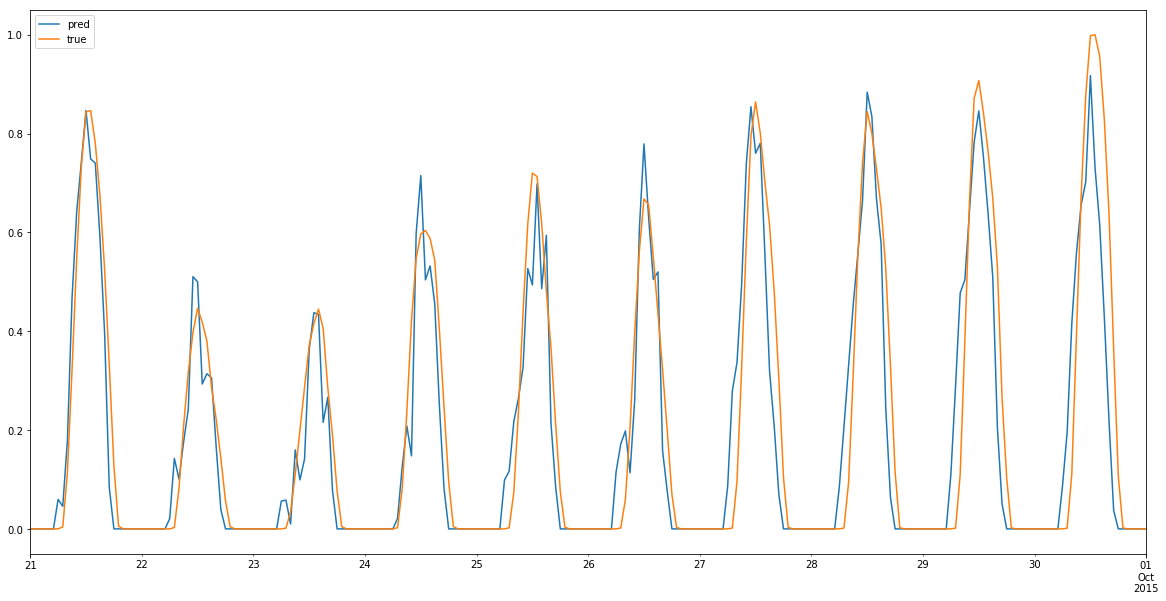

In [35]:
df['2015-09-21':].plot(figsize=(20,10))